In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
import lightkurve
from astropy import units
from astropy.io import fits
# import exoplanet as xo

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/caleb/.lightkurve/cache. Please move all the files in the legacy directory /Users/caleb/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)
ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])
names = np.array(m_dwarf_sample[m_dwarf_sample.columns[2]])
masses = np.array(m_dwarf_sample[["Mass"]])
comps = [i[0].strip() for i in np.array(m_dwarf_sample[["Comp"]])]

ras = [i.replace(' ',':') for i in ra]
decs = [i.replace(' ',':') for i in dec]

coords = []
for i in range(len(decs)):
    coords.append(ras[i]+" "+decs[i])

In [3]:
all_star_sample = pd.read_csv('/Users/caleb/research/Astro_98/all_stars_mags_mass.csv',delimiter=',',index_col=0)
gjs = np.array(all_star_sample['GJ'])
comps = np.array(all_star_sample['Comp'])

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/heavy_names.pkl','rb') as f:
    names = pickle.load(f)

In [4]:
# download data

def download_data():

    lc_datas = []
    for i in tqdm(range(len(coords))):
        try:
            search_result = lightkurve.search_lightcurve(coords[i],exptime='fast',mission='TESS')
            # search_result.table["dataURL"] = search_result.table["dataURI"]  # workaround MAST issue
            data = search_result.download_all()
            lc_datas.append(data)
        except:
            search_result = lightkurve.search_lightcurve(coords[i],exptime='fast',mission='TESS')
            search_result.table["dataURL"] = search_result.table["dataURI"]  # workaround MAST issue
            data = search_result.download_all()
            lc_datas.append(data)


In [5]:
with open(f'/Users/caleb/research/Astro_98/lightkurve_data/perio_data/stars_analyzed.pkl','rb') as f:
    pw = pickle.load(f)

In [6]:
def split_obs(lcs):
    result = []
    current_subarray = [lcs[0]]

    for i in range(1, len(lcs)):
        if abs(lcs.sector[i]-lcs.sector[i - 1]) < 3:
            current_subarray.append(lcs[i])
        else:
            result.append(current_subarray)
            current_subarray = [lcs[i]]

    result.append(current_subarray)
    result = [lightkurve.LightCurveCollection(i) for i in result]
    return result

In [8]:
def get_paths(target):
    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)
    all_paths = []

    if target == '':
        for num in range(1000):
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/{num}_*_lc.fits"))]
            all_paths.append(file_paths)

    else:
        file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/{target}_*_lc.fits"))]
        all_paths.append(file_paths)

    return all_paths


In [9]:
perio_frequency = np.arange(2, 2160,0.008)
frequency_hz = [(i*10**6)/(24*60*60) for i in np.array(perio_frequency)]
plt.plot(frequency_hz,summed_perio)
plt.xlabel("Frequency [uHz]")
plt.ylabel("Power")
plt.yscale('log')

NameError: name 'summed_perio' is not defined

In [25]:
def process(lc,smooth_size): 
    # flatten and remove flares

    flare_lc_flat ,flare_trend = lc.remove_nans().flatten(window_length=smooth_size, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)

    fig,ax = plt.subplots(1,1,figsize=(20,10))
    flare_lc_flat.scatter(ax=ax,color='red')
    ax.set_title("Flare LC RESIDUALS")
    plt.show()
    flare_trend.plot(color='green')
    plt.show()

    return
    # flare_lc_flat['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6

    clean_lc = lc.remove_nans().remove_outliers(3)

    fi = clean_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008))
    fi.plot(scale='log')
    print(fi.frequency.value[list(fi.power.value).index(np.max(fi.power.value))])
    # clean_lc.plot()
    ppm_unit = clean_lc.flux[0].unit
    flat_lc, trend_lc = clean_lc.flatten(window_length=smooth_size, polyorder=3, return_trend=True, break_tolerance=5, niters=3, sigma=3)
    flat_lc = flat_lc.remove_outliers(3)
    trend_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).plot(scale='log')
    plt.show()
    

    
    fig, axs = plt.subplots(1,1,figsize=(30,20))
    trend_lc.plot(color='orange',ax=axs)
    plt.show()
    # residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
    # flat_lc['flux'] = residuals
    flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6
    # flat_lc = flat_lc.remove_outliers(3)
    # get perio
    # frequency = np.arange(1, 4000,0.008)
    # flat_lc.plot()

    perio = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008))
    threshold =  4*np.mean(np.array(perio.power))
    threshold_freq = [(i*10**6)/(24*60*60) for i in np.array(perio.smooth(filter_width=20).frequency)]
    # perio = perio.smooth(filter_width=2)
    perio_psd = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 25000,.1),normalization='psd').smooth(filter_width=2)

    # get thresholds
    # flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).plot()
    # plt.axhline(y=threshold,color='red')
    # plt.show()
    # # perio_psd.plot(scale='log')
    # plt.show()
    
    frequency_hz = [(i*10**6)/(24*60*60) for i in np.arange(2, 2160,0.008)]
    # indices
    # plt.figure(figsize=(10,5))
    # plt.plot(frequency_hz,np.array(flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).power),color='black',alpha=.8)
    # plt.xlabel("Frequency [uHz]",fontsize=15)
    # plt.ylabel("Amp. [ppm]",fontsize=15)
    # plt.axhline(y=threshold,color='red')
    # plt.tick_params(labelsize=10)
    # # plt.xscale('log')
    # plt.show()
    print('max',frequency_hz[np.argmax(np.array(perio.power))])
    return perio, perio_psd, threshold, flat_lc

In [11]:
def get_perio(lc_data,smooth_size):
    consecutive_lcs = split_obs(lc_data)

    perios = []
    perio_psds = []
    flats = []


    thresholds = []


    for lcs in consecutive_lcs:
        if len(lcs) > 1:    
            lc = lcs.stitch().normalize(unit='ppm')
            perio, perio_psd,threshold,flat_lc = process(lc,smooth_size)
            ppm_unit = perio.power[0].unit
            psd_unit = perio_psd.power[0].unit
            perios.append(np.array(perio.power))
            perio_psds.append(np.array(perio_psd.power))
            thresholds.append(threshold)
        else:
            for lc in lcs:
                lc = lc.normalize(unit='ppm')
                perio, perio_psd,threshold,flat_lc = process(lc,smooth_size)
                ppm_unit = perio.power[0].unit
                psd_unit = perio_psd.power[0].unit
                thresholds.append(threshold)
                perios.append(np.array(perio.power))
                perio_psds.append(np.array(perio_psd.power))

    
    summed_perio = sum(perios)
    summed_perio_psd = sum(perio_psds)

    perio.power = np.array(summed_perio)*ppm_unit
    perio_psd.power = np.array(summed_perio_psd)*psd_unit
    return perio, perio_psd, np.min(thresholds),flat_lc

In [12]:
def get_fake_lc(lc):
    rand = np.random.default_rng(42)
    lc = lc.remove_nans()
    t = lc.time.value
    clean_lc = lc.remove_outliers(4)


    noise = np.std((clean_lc['flux'])) * np.random.normal(size=len(t))
    baseline = np.mean((clean_lc['flux']))


    lc['flux'] = (noise+baseline)
    print(lc['flux'])

    return lc

In [13]:
def analyze_star(star_num,fake,smooth_size):

    all_paths = get_paths('')
    print(all_paths)
    powers = []
    power_psds = []
    flats = []
    thresholds = []
    dilutions = []
    stars_analyzed = []

    stars = [star_num]

    for num in stars:
        # try:
            if len(all_paths[num]) != 0:
                if len(all_paths[num]) > 0:
                    print(all_paths[num])
                    lcs_list = []

                    # if exp_time != 'fast': 
                    #     search_result = lk.search_lightcurve('GJ 1243',mission='TESS',exptime=exp_time)
                    #     lc = search_result[1].download()
                    #     lcs_list.append(lc)

                    for i in all_paths[num]:
                        lc = lightkurve.io.read(f'{i}')
                        if fake == True:
                            lc = get_fake_lc(lc)
                        # lc.plot()
                        lcs_list.append(lc)
                lcs = lightkurve.LightCurveCollection(lcs_list)
                # else:
                #     lc = lightkurve.io.read(f'{all_paths[num][0]}')

                #     # make fake data
                #     if fake == True:
                #         lc = get_fake_lc(lc)
                #     lcs = lightkurve.LightCurveCollection(lc)

                print(lcs)
                # get contamination
                dilution = lc.meta["CROWDSAP"]

                # sort lightkurves by sector
                sorted_indexes = sorted(range(len(lcs.sector)), key=lambda x: lcs.sector[x])
                lcs = lcs[sorted_indexes]
                perio, perio_psd,threshold,flat_lc = get_perio(lcs,smooth_size)

                # perio.plot(scale='log')
                # perio_psd.plot(scale='log')

                fig, axs = plt.subplots(2,1,figsize=(10,10))
                lc.remove_outliers().scatter(ax=axs[0],color='black',alpha=.9)

                flat = perio_psd.flatten()
                flat.plot(ax=axs[1],title=f'Star {num} -- {names[num]} {comps[num]}',color='black',alpha=.9)
                axs[0].tick_params(labelsize=20)
                axs[1].tick_params(labelsize=20)
                plt.rcParams.update({'font.size': 30})
                plt.tight_layout()
                axs[0].set_xlabel("Time [d]",fontsize=25)
                axs[0].set_ylabel("Flux [e/s]",fontsize=25)
                axs[1].set_xlabel("Frequency [uHz]",fontsize=25)
                axs[1].set_ylabel("SNR",fontsize=25)

                plt.savefig(f'lightkurve_data/power_plots/{num}_flat_power.png')
                plt.show()
                plt.close()
                perio_freq = perio.frequency.value
                frequency_microhertz = [(i*10**6)/(24*60*60) for i in perio_freq]

                # fig, axs = plt.subplots(2,2,figsize=(20,10))

                # # lc.scatter(ax=axs[0][0])
                # # flat_lc.scatter(ax=axs[0][1])
                # # perio.plot(ax=axs[1][0])
                # # perio_psd.plot(ax=axs[1][1])


                # axs[0][0].scatter(lc.time.value,lc.flux.value,color='black',alpha=.8)
                # axs[0][1].scatter(flat_lc.time.value,flat_lc.flux.value,color='black',alpha=.8)
                # axs[1][0].scatter(frequency_microhertz,perio.power.value,color='black',alpha=.8)
                # axs[1][1].scatter(perio_psd.frequency.value,perio_psd.power.value,color='black',alpha=.8)


                
                # axs[1][1].set_xscale('log')
                # axs[1][1].set_yscale('log')

                # plt.tick_params(axis='both', which='major', labelsize=22)
                
                # plt.show()

                perio.frequency = frequency_microhertz*perio_psd.frequency.unit

                fig, axs = plt.subplots(2,1,figsize=(10,12))
                lc.remove_outliers().scatter(ax=axs[0],color='black',alpha=.8,s=1)
                perio.plot(ax=axs[1],color='black',alpha=.8)
                axs[1].axhline(y=4*(np.mean(perio.power.value)),color='red',alpha=.9)
                axs[1].set_xlim(20,25000)

                for ax in axs.flat:
                    size = 25
                    ax.xaxis.label.set_size(size)
                    ax.yaxis.label.set_size(size)
                    ax.tick_params(axis='both', which='both', labelsize=size)

                plt.tight_layout()
                plt.savefig('/Users/caleb/Desktop/98Graphs/interesting_transits')
                plt.show()

                perio_psd =perio_psd[2000:]
                fig, axs = plt.subplots(1,2,figsize=(20,10))
                perio_psd.plot(ax=axs[0],color='black',alpha=.8,scale='log')
                perio_psd.plot(ax=axs[1],color='black',alpha=.8)

                axs[0].set_xlim(200,25000)
                axs[1].set_xlim(400,1000)

                for ax in axs.flat:
                    size = 25
                    ax.xaxis.label.set_size(size)
                    ax.yaxis.label.set_size(size)
                    ax.tick_params(axis='both', which='both', labelsize=size)

                plt.tight_layout()
                plt.savefig('/Users/caleb/Desktop/98Graphs/companion_oscillations')
                plt.show()


                plt.rcParams["font.family"] = "Times New Roman"
                fig, axs = plt.subplots(2,2,figsize=(20,10))
    
                lc.scatter(ax=axs[0][0],color='black',alpha=.8)
                flat_lc.scatter(ax=axs[0][1],color='black',alpha=.8)
                perio.plot(ax=axs[1][0],color='black',alpha=.8)
                perio_psd.plot(ax=axs[1][1],color='black',alpha=.8,scale='log')
                axs[1][0].axhline(y=4*(np.mean(perio.power.value)),color='red',alpha=.9)
                axs[1][1].set_xlim(200,25000)
                axs[0][1].set_ylabel('Residual Flux [ppm]')

                for ax in axs.flat:
                    size = 25
                    ax.xaxis.label.set_size(size)
                    ax.yaxis.label.set_size(size)
                    ax.tick_params(axis='both', which='both', labelsize=size)

                plt.subplots_adjust(hspace=0.25, wspace=.25)
                plt.tight_layout()
                plt.savefig('/Users/caleb/Desktop/98Graphs/pipeline')
                plt.show()

            


                # get maximum value and zoom in on it
                # print(flat)
                # print(np.argmax(np.array(flat.power)))
                # freq_index_mas = flat.frequency.

                fig, axs = plt.subplots(1,2,figsize=(20,10))
                max_index = list(flat.frequency).index(flat.frequency[np.argmax(flat.power)])
                perio_psd[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=axs[0],color='black',alpha=.85)
                flat[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=axs[1],color='black',alpha=.85)
                plt.show()


                fig, ax = plt.subplots(1,1,figsize=(12,8))

                perio_psd[max_index-int(.3*max_index)-2000:max_index+int(.3*max_index)-2000].plot(ax=ax,color='black',alpha=0)
                # flat[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=ax,color='red',alpha=0,linewidth=2)
                normalization = np.max(perio_psd.power.value)/np.max(flat.power.value)

                ax.plot(flat.frequency.value,normalization*flat.power.value,color='red')
                ax.plot(perio_psd.frequency.value,perio_psd.power.value,color='black',alpha=.85)


                                
                ax.set_xlim(flat.frequency.value[max_index-int(.3*max_index)],flat.frequency.value[max_index+int(.3*max_index)])
                plt.tight_layout(pad=.5)

                plt.savefig('/Users/caleb/Desktop/98Graphs/firstTIC')

                # flat_perio = perio.smooth(filter_width=2)
                # flat_perio.plot(color='red')
                powers.append(perio.power)
                power_psds.append(perio_psd.power)
                thresholds.append(threshold)
                flats.append(np.array(flat.power))
                dilutions.append(dilution)
                stars_analyzed.append(num)

            else:
                powers.append(np.array([]))
                power_psds.append(np.array([]))
                thresholds.append(-1)
                flats.append(np.array([]))
                dilutions.append(-1)
                stars_analyzed.append(num)
        # except:
        #     print("error on star: ",num)



    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/thresholds.pkl','wb') as f:
        pickle.dump(thresholds,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/power_psds.pkl','wb') as f:
        pickle.dump(power_psds,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/flats.pkl','wb') as f:
        pickle.dump(flats,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/powers.pkl','wb') as f:
        pickle.dump(powers,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/dilutions.pkl','wb') as f:
        pickle.dump(dilutions,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/stars_analyzed.pkl','wb') as f:
        pickle.dump(stars_analyzed,f)



In [28]:
pip install celerite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 4.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [89]:
lc

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,electron / s,electron / s,,,,,,
Time,float32,float32,int32,float64,float64,float64,float64,int32
2201.7372983989903,44327.8359375,73.03826904296875,4208880,1925.7113521514234,1925.7113521514234,717.1551127912015,717.1551127912015,0
2201.7375298859565,44059.77734375,72.97876739501953,4208881,1925.6937289650778,1925.6937289650778,717.176714210309,717.176714210309,0
2201.7377613724566,44268.96875,73.0525131225586,4208882,1925.7065214965114,1925.7065214965114,717.153309972655,717.153309972655,0
2201.7379928594223,44153.03515625,73.00959777832031,4208883,1925.740067745123,1925.740067745123,717.1741455449546,717.1741455449546,0
2201.7382243463885,44196.90625,73.07063293457031,4208884,1925.6885024233643,1925.6885024233643,717.1815604534834,717.1815604534834,0
2201.7384558333547,44289.19140625,73.0536117553711,4208885,1925.722787057145,1925.722787057145,717.1554843648605,717.1554843648605,0
2201.7386873198548,44230.32421875,73.03824615478516,4208886,1925.7290021856634,1925.7290021856634,717.1538973960281,717.1538973960281,0
2201.7391502937867,44186.5078125,73.02528381347656,4208888,1925.6829606578046,1925.6829606578046,717.1593651579004,717.1593651579004,0


In [91]:
y = lc.flux.value[-5000:]
t = lc.time.value[-5000:]
yerr = lc.flux_err.value[-5000:]

In [86]:
import exoplanet

In [88]:
# exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.3.3'


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

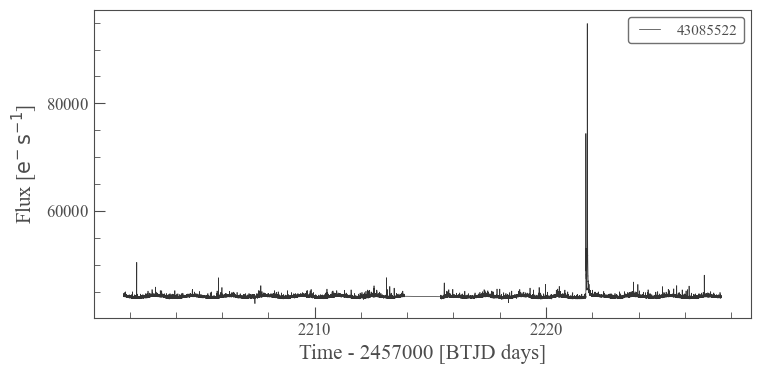

In [114]:
lc.plot()

In [92]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

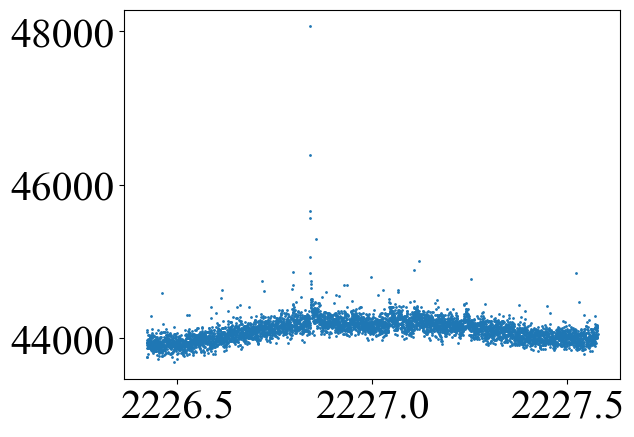

In [93]:
plt.scatter(t,y,s=1)

In [113]:
len(t)

5000

In [94]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

Initial log likelihood: -32334.43434987519
      fun: 31555.45496469275
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  10.94122036, 1047.00885185,    5.41112923,  158.78831627,
        299.83857712])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 228
      nit: 6
     njev: 38
   status: 0
  success: True
        x: array([10.58972564,  4.52601792, 10.30378549, -0.15109283,  3.75909248])


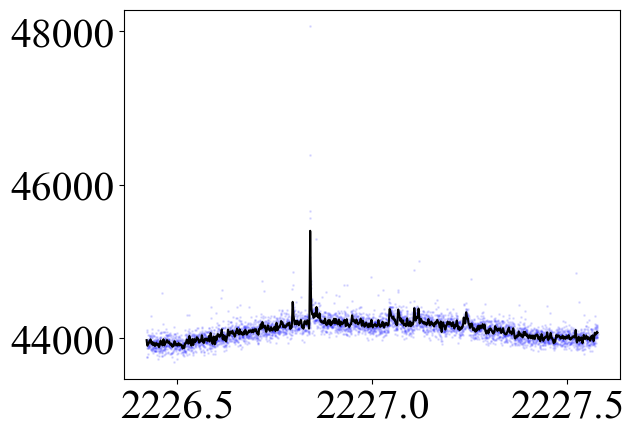

In [95]:
x = np.linspace(t[0], t[-1], len(t))
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(t, y, s=1,color='blue', alpha=0.1)
plt.plot(x, pred_mean, color='black')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='black', alpha=0.3,
                 edgecolor="none")



In [99]:
import exoplanet as xo

mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=0.1, max_period=2.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]

In [100]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(peak["period"]), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

TypeError: The 'inputs' argument to Apply must contain Variable instances, not Assert{msg='Theano Assert failed!'}.0

In [112]:
with pm.Model() as model:
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)
    print(log_jitter)

log_jitter


In [111]:
log_jitter

TypeError: Outputs must be theano Variable or Out instances. Received TensorConstant{0.5031113624572754} of type <class 'theano.tensor.var.TensorConstant'>

log_jitter

[[], ['/Users/caleb/research/Astro_98/lightkurve_data/1_0_lc.fits'], [], ['/Users/caleb/research/Astro_98/lightkurve_data/3_1_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/3_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/4_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/4_1_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/5_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/5_1_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/6_2_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/6_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/6_1_lc.fits'], [], ['/Users/caleb/research/Astro_98/lightkurve_data/8_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/9_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/9_1_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/10_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/11_0_lc.fits'], ['/Users/caleb/research/Astro_98/ligh

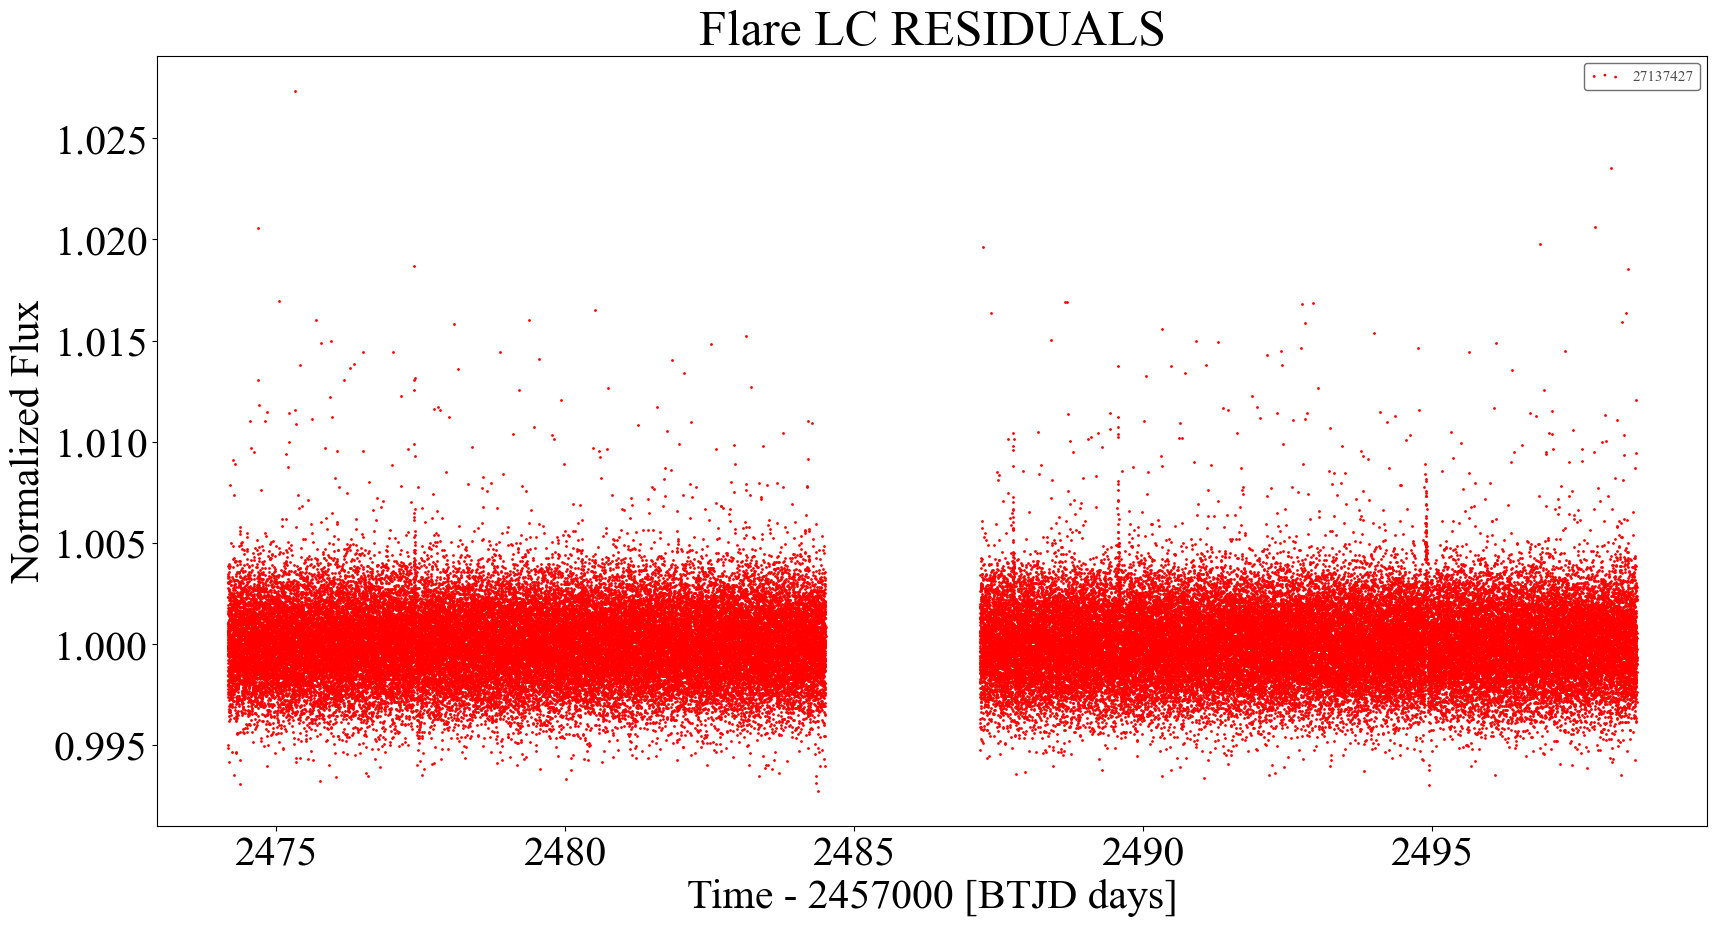

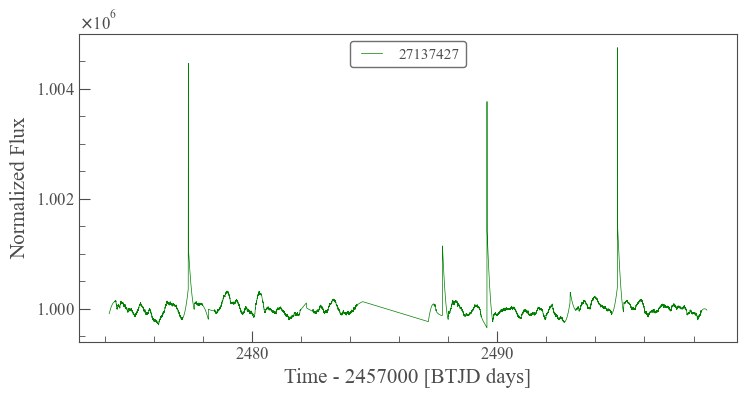

TypeError: cannot unpack non-iterable NoneType object

In [26]:
analyze_star(111,False,2001)

In [ ]:
mult = [(126, 19),
 (134, 19),
 (145, 20),
 (146, 20),
 (149, 18),
 (166, 19),
 (189, 12),
 (190, 12),
 (356, 12),
 (357, 12),
 (359, 15),
 (360, 15),
 (387, 13),
 (397, 14),
 (399, 12),
 (409, 26),
 (428, 16)]

In [ ]:
for i in mult:
    analyze_star(i[0],False,2001)

In [ ]:
analyze_star(0,False,2001)

In [ ]:
analyze_star(134,False,smooth_size = 31,exp_time='short')

In [ ]:
analyze_star(134,False,smooth_size = 31,exp_time='fast')

In [ ]:
m_dwarf_sample[134]

In [ ]:
analyze_star(134,False,smooth_size = 2001)

In [ ]:
# real data
analyze_star(15)

In [ ]:
analyze_star(134,False,501)

In [ ]:
# fake data


In [ ]:
## load analyzed data


with open(f'/Users/caleb/research/Astro_98/lightkurve_data/thresholds.pkl','rb') as f:
    thresholds = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/power_psds.pkl','rb') as f:
    power_psds = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/flats.pkl','rb') as f:
    flats = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/powers.pkl','rb') as f:
    powers = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/dilutions.pkl','rb') as f:
    dilutions = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/stars_analyzed.pkl','rb') as f:
    stars_analyzed = pickle.load(f)


In [ ]:
ppm_unit = lc.flux[0].unit
clean_lc = lc.remove_nans().remove_outliers()
flat_lc, trend_lc = clean_lc.flatten(window_length=201, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)
residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
# flat_lc['flux'] = residuals
flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6
flat_lc.plot()

In [ ]:
flat_lc

In [ ]:
frequency = np.arange(1000, 4000,0.008)
perio = lc.normalize(unit='ppm').to_periodogram(method='lombscargle',frequency=np.arange(2, 4000,0.008)).smooth(filter_width=2)
perio_psd = lc.normalize(unit='ppm').to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,0.008),normalization='psd').smooth(filter_width=2)

In [ ]:
perio.power[0].unit

In [ ]:
perio.plot(scale='log')

In [ ]:
plt.plot(np.array(perio.frequency),np.array(perio.power))
plt.xlim(100,4000)

In [ ]:
perio_psd.power

In [ ]:
perio_psd.plot(scale='log')

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,electron / s,electron / s,,,,,,
Time,float32,float32,int32,float64,float64,float64,float64,int32
2201.7372983989903,44327.8359375,73.03826904296875,4208880,1925.7113521514234,1925.7113521514234,717.1551127912015,717.1551127912015,0
2201.7375298859565,44059.77734375,72.97876739501953,4208881,1925.6937289650778,1925.6937289650778,717.176714210309,717.176714210309,0
2201.7377613724566,44268.96875,73.0525131225586,4208882,1925.7065214965114,1925.7065214965114,717.153309972655,717.153309972655,0
2201.7379928594223,44153.03515625,73.00959777832031,4208883,1925.740067745123,1925.740067745123,717.1741455449546,717.1741455449546,0
2201.7382243463885,44196.90625,73.07063293457031,4208884,1925.6885024233643,1925.6885024233643,717.1815604534834,717.1815604534834,0
2201.7384558333547,44289.19140625,73.0536117553711,4208885,1925.722787057145,1925.722787057145,717.1554843648605,717.1554843648605,0
2201.7386873198548,44230.32421875,73.03824615478516,4208886,1925.7290021856634,1925.7290021856634,717.1538973960281,717.1538973960281,0
2201.7391502937867,44186.5078125,73.02528381347656,4208888,1925.6829606578046,1925.6829606578046,717.1593651579004,717.1593651579004,0


In [34]:
# grab all paths

all_paths = get_paths('')
lcs = []
lcs_list = []
for i in all_paths[143]:
    lc = lightkurve.io.read(f'{i}')
    lcs_list.append(lc)
lcs = lightkurve.LightCurveCollection(lcs_list)

print(lcs)


LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="711366839" SECTOR=33 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="43085522" SECTOR=33 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [ ]:
lc = lcs[0]
# lc.plot()
plt.plot(lc.time.value,lc.flux)
plt.xlim(2210,2210.1)
plt.ylim(33500,36500)

In [ ]:
lc.normalize().flatten().plot()

In [ ]:
lcs[0]

In [ ]:
## Dilution
dilution = lcs[0].meta["CROWDSAP"]
print(dilution)

In [ ]:
tic = 57984826

tess_lcfs = lk.search_lightcurve("LHS 112", mission="TESS", author="SPOC", exptime="fast").download_all(quality_bitmask="default", flux_column='pdcsap_flux')
print(tess_lcfs)
for ii, lc in enumerate(tess_lcfs):
    dilution = lc.meta["CROWDSAP"]
    print(dilution)

In [ ]:
lcs[0]

In [ ]:
tess_lcfs[0]

In [ ]:
import numpy as np
ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/s4tess_llrgb.asc")

In [ ]:
print(ascii_grid[0:10])

In [ ]:
plt.plot(ascii_grid)
plt.show()